In [1]:
import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

TOTAL_ROWS= 2228278
INPUT_ROWS_LIMIT= TOTAL_ROWS # setting this over 1,000,000 causes a bug
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATION_ID= 117
SECS_IN_5MIN= 300
DATAPOINTS_PER_DAY= 288
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1]
TOTAL_DAYS= 91
MAX_DISPLAYED_STATIONS= 1
MAX_DISPLAYED_DAYS= 20

class DataDay: # ideally this would be nested in the Station class
    def __init__(self, index):
        self.index= index
        self.daily_epoch_time= []
        self.epoch_time= []
        self.percent_bikes_available= []

    def populate(self, daily_epoch_time, epoch_time, percent_bikes_available):
        self.daily_epoch_time.append(daily_epoch_time)
        self.epoch_time.append(epoch_time)
        self.percent_bikes_available.append(percent_bikes_available)

class Station:
    def __init__(self, index):
        self.index= index
        self.name= -1
        self.bike_capacity= -1 # populating with -1 initially as a debugging means
        self.address= -1
        self.latitude= -1
        self.longitude= -1
        self.data_days= [DataDay(i) for i in range(1, TOTAL_DAYS + 3)]
    
    def populate_consts(self, name, bike_capacity, address, latitude, longitude):
        self.name= name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

def get_station_id(name):
    try:
        index= [x.name for x in stations].index(name)
    except ValueError:
        index= -1
    return index

In [2]:
index= []; daily_epoch_time= []; epoch_time= []; percent_bikes_available= [];
stations= [Station(i) for i in range(1, MAX_STATION_ID + 1)] # note: MAX_STATION_ID + 1 is not included in the range
indices_to_populate= list(range(1, MAX_STATION_ID + 1))
for index in MISSING_STATIONS:
    indices_to_populate.remove(index)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip data header
    current_index= 0
    try:
        while len(indices_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_index: # this 'if' is just for performance
                continue
            current_index= int(row[0])
            if current_index in indices_to_populate:
                stations[current_index - 2].populate_consts(row[3], row[4], row[8], row[9], row[10])
                indices_to_populate.remove(current_index)
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip data header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            try:
                epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(2020,1,1,0,0)).total_seconds() / SECS_IN_5MIN) # the unit of epoch_time is 5-minutes
                stations[int(row[0]) - 1].data_days[int(epoch_time / DATAPOINTS_PER_DAY) + 1].populate( \
                    int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / SECS_IN_5MIN), \
                    epoch_time, \
                    float("{:.3f}".format(float(row[6]) / float(row[4]))))
            except IndexError as e:
                print("\nTRIED: ", epoch_time, ' / ', DATAPOINTS_PER_DAY, ' = ', int(epoch_time / DATAPOINTS_PER_DAY))
                print(row[1])
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))

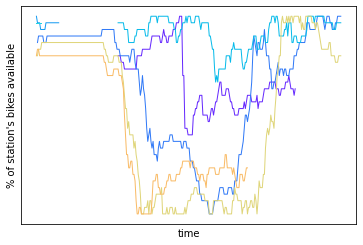

In [4]:
def station_graph(index):
    if MAX_DISPLAYED_DAYS < TOTAL_DAYS:
        colors= cm.rainbow(np.linspace(0, 1, MAX_DISPLAYED_DAYS))
    else:
        colors= cm.rainbow(np.linspace(0, 1, TOTAL_DAYS))

    for (day_i, day), c in zip(enumerate(stations[index].data_days), colors): # use day_i + 1 to access days because day 0 is empty but kept so that the day's date works as an array index too
        if day_i >= MAX_DISPLAYED_DAYS:
            break
        #plt.scatter(station.daily_epoch_time, station.percent_bikes_available, 1, marker="*", color= c, linewidth=0.0001)
        plt.plot(day.daily_epoch_time, day.percent_bikes_available, 1, color= c, linewidth=1)
    plt.ylabel('% of station\'s bikes available')
    plt.xlabel('time')
    plt.xticks(())
    plt.yticks(())

    plt.show()

    #plt.scatter(daily_epoch_time, percent_bikes_available,  color='black')

station_graph(get_station_id('PORTOBELLO ROAD'))